In [1]:
!pip install opendatasets --upgrade --quiet
!pip install jovian --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Importing libraries

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import opendatasets as od
import os
%matplotlib inline

# Importing dataset and pre-processing

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/puneet6060/intel-image-classification'
od.download(dataset_url)

100%|██████████| 346M/346M [00:15<00:00, 23.2MB/s]


In [4]:
data_dir = './intel-image-classification'

In [5]:
os.listdir(data_dir+'/seg_train/seg_train')

['buildings', 'glacier', 'street', 'mountain', 'forest', 'sea']

In [6]:
stats = ((0.4951, 0.4982, 0.4979), (0.2482, 0.2467, 0.2807))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

buildings


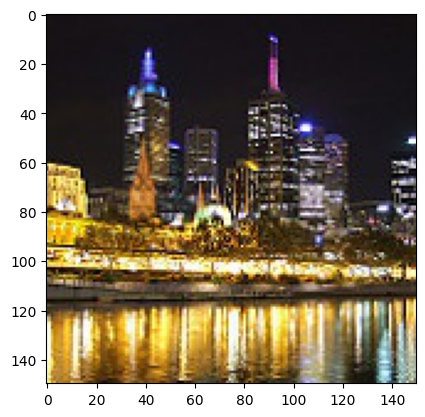

In [7]:
train=ImageFolder(data_dir+"/seg_train/seg_train")
img, label = train[153]
print(train.classes[label])
plt.imshow(img)

In [8]:
train.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [9]:
train = ImageFolder(data_dir+"/seg_train/seg_train", transform = train_transform)
test = ImageFolder(data_dir+"/seg_test/seg_test",transform = test_transform)

buildings


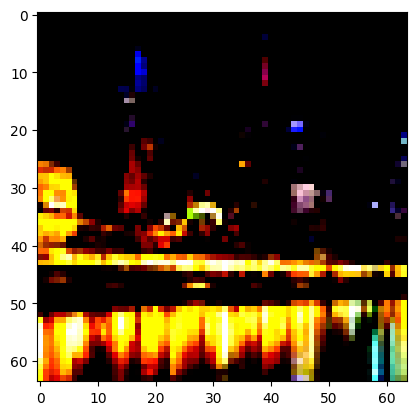

In [10]:
img, label = train[153]
print(train.classes[label])
plt.imshow(img.permute((1,2,0)))

In [11]:
random_seed = 42
torch.manual_seed(random_seed);

In [12]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(11228, 2806)

In [13]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

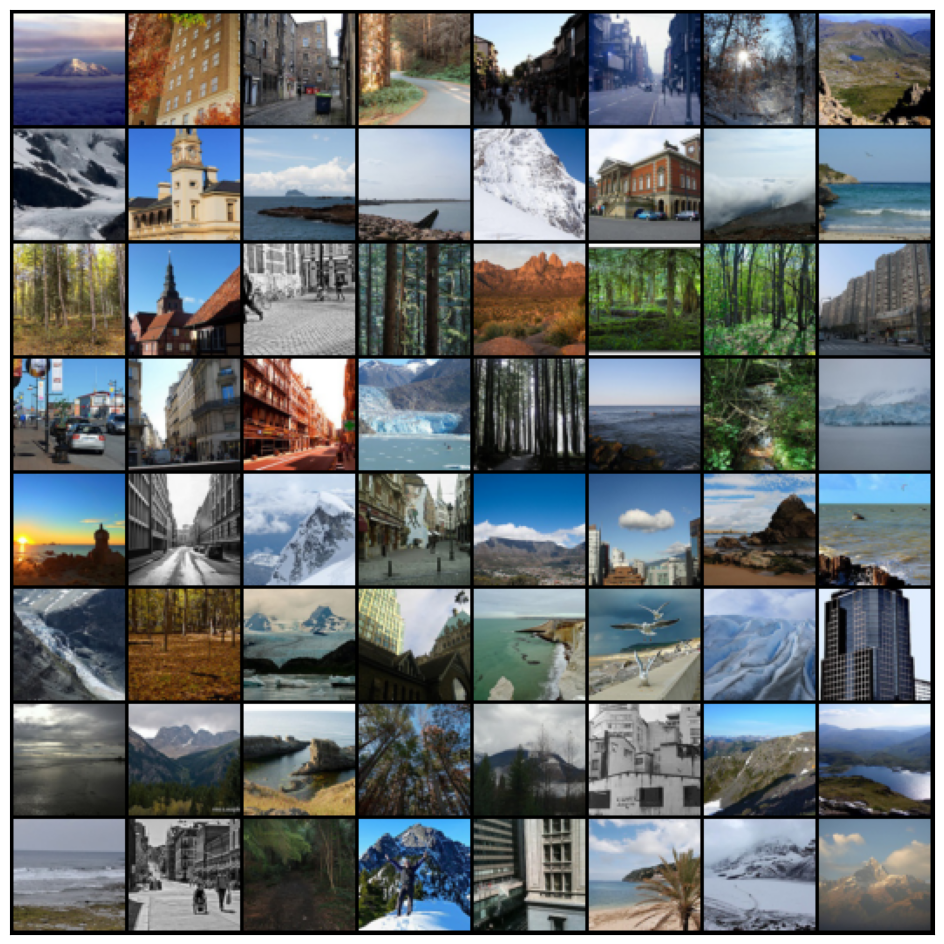

In [14]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

# Moving to GPU

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Extending ImageClassificationBase class

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Building Model

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [19]:
class IntelModel(ImageClassificationBase):
  def __init__(self,inp,num_class):
    super().__init__()
    self.conv1 = conv_block(inp,64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_class))

  def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.res1(out) + out
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out
      out = self.classifier(out)
      return out


In [20]:
model = IntelModel(3,len(train.classes))

In [21]:
model

IntelModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [22]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(model, device)

# Training the Model

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, max_lr, model, train_loader, val_loader,weight_decay, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.7904870510101318, 'val_acc': 0.16969813406467438}]

In [25]:
history += fit(12,0.01,model,train_dl,valid_dl,1e-4,torch.optim.Adam)

Epoch [0], train_loss: 0.9980, val_loss: 0.7462, val_acc: 0.7341
Epoch [1], train_loss: 0.7412, val_loss: 0.7723, val_acc: 0.7366
Epoch [2], train_loss: 0.6986, val_loss: 1.4367, val_acc: 0.5848
Epoch [3], train_loss: 0.6609, val_loss: 0.6414, val_acc: 0.7772
Epoch [4], train_loss: 0.5464, val_loss: 1.5753, val_acc: 0.5898
Epoch [5], train_loss: 0.4668, val_loss: 0.4759, val_acc: 0.8292
Epoch [6], train_loss: 0.4079, val_loss: 0.4964, val_acc: 0.8253
Epoch [7], train_loss: 0.3494, val_loss: 0.4603, val_acc: 0.8510
Epoch [8], train_loss: 0.2943, val_loss: 0.3398, val_acc: 0.8812
Epoch [9], train_loss: 0.2439, val_loss: 0.3521, val_acc: 0.8819
Epoch [10], train_loss: 0.2001, val_loss: 0.2954, val_acc: 0.8995
Epoch [11], train_loss: 0.1724, val_loss: 0.2969, val_acc: 0.8980


# Plotting Loss and Accuracy

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

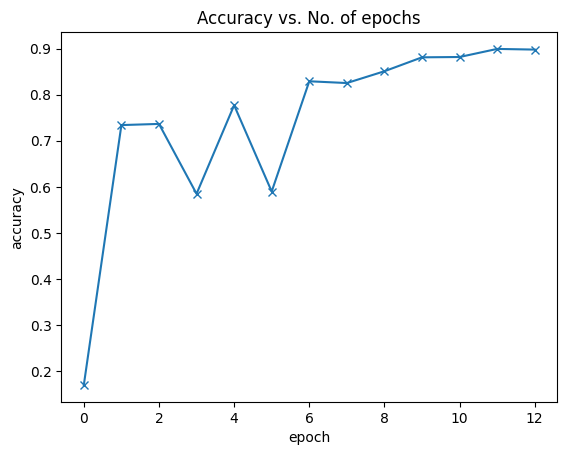

In [27]:
plot_accuracies(history)

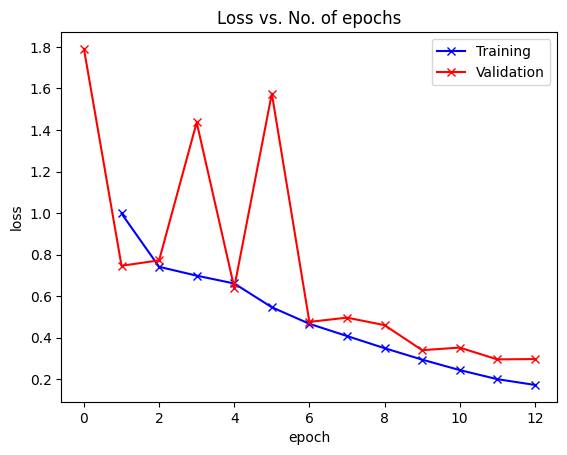

In [28]:
plot_losses(history)

# Predictions on dataset

In [29]:
def predict(img,model):
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  _,preds = torch.max(yb,dim=1)
  return train.classes[preds[0].item()]

Label: street , Predicted: street


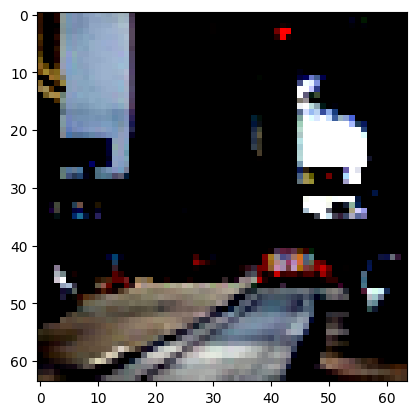

Label: sea , Predicted: sea


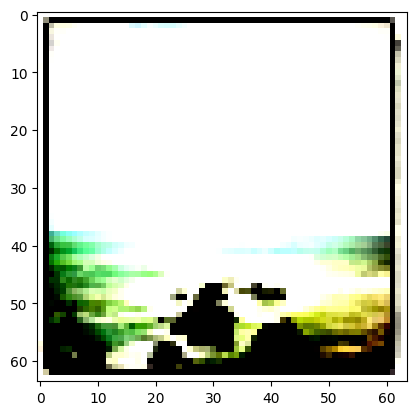

Label: glacier , Predicted: glacier


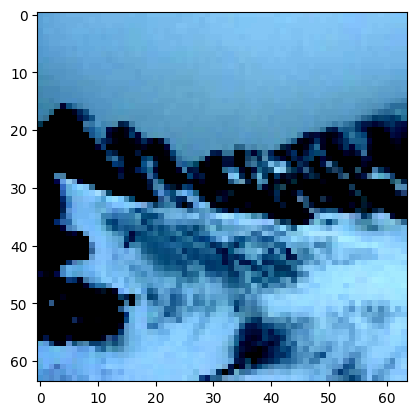

Label: glacier , Predicted: glacier


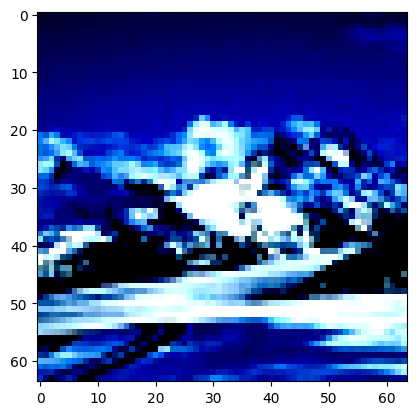

In [30]:
import random
for i in range(0,4):
  img,label = random.choice(test)
  print('Label:', train.classes[label], ', Predicted:', predict(img, model))
  plt.imshow(img.permute(1, 2, 0))
  plt.show()

# Evaluating model on test dataset

In [31]:
result = evaluate(model, test_dl)
print(result)

{'val_loss': 0.2855830192565918, 'val_acc': 0.8995273113250732}


# Save the Model

In [32]:
torch.save(model.state_dict(), './Intel_class.pth')

# Record results

In [ ]:
import jovian

jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,
                       epochs=12,
                       arch='CNN',
                       lrs=[0.01],
                       opt=['Adam','SGD'])
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc'],
                   val_loss = history[-1]['val_loss']
                   )

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [ ]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
